In [42]:
from sklearn.cluster import KMeans
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import GaussianNoise
from keras.callbacks import EarlyStopping

# sns.set(style="whitegrid")
# np.random.seed(203)


In [2]:
!unzip "/content/archive.zip"

Archive:  /content/archive.zip
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: creditcard.csv          


In [3]:
data = pd.read_csv("/content/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
classStats = data['Class'].value_counts().to_frame().reset_index()
classStats['percent'] = classStats["Class"].apply(lambda x : round(100*float(x) / len(data), 2))
classStats = classStats.rename(columns = {"index" : "ClassLabel", "Class" : "count"})
classStats

,ClassLabel,count,percent
0,0,284315,99.83
1,1,492,0.17


As it can be seen our data is significantly imbalanced and we need to do something about it.



In [5]:
data.shape

(284807, 31)

In [6]:
nun_rows = data[data.isnull().sum(axis=1)>0.0].index
nun_rows

Int64Index([], dtype='int64')

The data has no nan values.

1. Clustering

let's remove outliers from our majority class data.

In [7]:
"""
df = data[data['Class']==0]

# Calculate the 25th and 75th percentiles for each column
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)

# Calculate the interquartile range (IQR) for each column
iqr = q3 - q1

# Define the lower and upper bounds for outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Create a boolean mask of outlier values for each column
mask = ((df < lower_bound) | (df > upper_bound))

# Combine the outlier masks of all columns using logical OR
outlier_mask = mask.any(axis=1)

# Filter the DataFrame to remove rows containing outliers
df_no_outliers = df[~outlier_mask]

# Print the DataFrame without outliers
print("DataFrame without outliers:")
print(df_no_outliers.shape)
"""

'\ndf = data[data[\'Class\']==0]\n\n# Calculate the 25th and 75th percentiles for each column\nq1 = df.quantile(0.25)\nq3 = df.quantile(0.75)\n\n# Calculate the interquartile range (IQR) for each column\niqr = q3 - q1\n\n# Define the lower and upper bounds for outliers\nlower_bound = q1 - 1.5 * iqr\nupper_bound = q3 + 1.5 * iqr\n\n# Create a boolean mask of outlier values for each column\nmask = ((df < lower_bound) | (df > upper_bound))\n\n# Combine the outlier masks of all columns using logical OR\noutlier_mask = mask.any(axis=1)\n\n# Filter the DataFrame to remove rows containing outliers\ndf_no_outliers = df[~outlier_mask]\n\n# Print the DataFrame without outliers\nprint("DataFrame without outliers:")\nprint(df_no_outliers.shape)\n'

In [8]:
"""
data = pd.concat([df_no_outliers,data[data['Class']==1]])
data.shape
"""

"\ndata = pd.concat([df_no_outliers,data[data['Class']==1]])\ndata.shape\n"

Here we standardize our datapoints and remove their labels.

In [9]:
data= data.sample(frac=1)

In [10]:
X = data.iloc[:,:30]
Y = data.iloc[:,30]
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
143961,85761.0,-3.123261,-2.687500,2.259697,1.440493,0.049930,-1.512294,-1.540200,0.630850,-1.412547,...,0.698233,0.093162,-0.495598,0.213959,0.900185,0.096134,-0.329658,0.035676,-0.395943,142.00
56168,47296.0,-0.337196,0.584943,0.633246,-1.769438,-0.935156,-1.639173,0.283909,0.177097,0.608499,...,-0.142909,0.126318,0.275257,0.086814,0.736905,-0.302196,-0.117656,-0.084872,-0.023158,30.15
127214,78247.0,1.006229,-1.364553,1.019069,-0.461272,-1.380435,0.938624,-1.305212,0.506348,0.010003,...,0.143676,0.162172,0.388815,-0.026186,-0.280205,0.131832,-0.210020,0.056805,0.024411,115.29
86857,61428.0,-3.299302,2.514588,0.252420,-1.372979,-1.463749,-1.609667,-0.257221,0.903757,0.751690,...,0.510735,-0.124463,-0.181794,0.057206,0.960352,-0.078672,0.659450,0.098824,0.132709,7.68
71539,54331.0,-0.191134,1.115185,0.643083,2.969246,0.821548,-0.728210,0.889989,-0.334860,-1.684789,...,0.054415,0.196095,0.730003,0.320321,0.430638,-0.981231,0.075527,0.153634,0.230645,1.18


In [11]:
scaler = MinMaxScaler()
# X['scaled_amount'] = scaler.fit_transform(np.array(X['Amount']).reshape(-1,1))
X.drop(columns=['Time'],inplace=True)
for column in X.columns:
    X[f'scaled_{column}'] = scaler.fit_transform(np.array(X[column]).reshape(-1,1))
    X.drop(columns=[column],inplace=True)

In [12]:
X.sample(10)

,scaled_V1,scaled_V2,scaled_V3,scaled_V4,scaled_V5,scaled_V6,scaled_V7,scaled_V8,scaled_V9,scaled_V10,...,scaled_V20,scaled_V21,scaled_V22,scaled_V23,scaled_V24,scaled_V25,scaled_V26,scaled_V27,scaled_V28,scaled_Amount
201700,0.962996,0.779428,0.839842,0.304547,0.769183,0.258225,0.269817,0.783343,0.436349,0.501480,...,0.583393,0.558465,0.494171,0.667787,0.522725,0.515166,0.506427,0.420487,0.318079,0.000308
27664,0.973376,0.753266,0.831987,0.232808,0.759348,0.258424,0.265369,0.783360,0.426571,0.522696,...,0.580699,0.557218,0.473658,0.661207,0.391382,0.597561,0.599832,0.414251,0.313717,0.010309
87309,0.943921,0.776456,0.830310,0.174314,0.780419,0.296171,0.264186,0.800172,0.452847,0.491729,...,0.580531,0.558179,0.477357,0.664360,0.519653,0.575847,0.476199,0.419804,0.315377,0.000039
139422,0.980615,0.751767,0.858380,0.187864,0.752032,0.263839,0.255017,0.786702,0.407366,0.539820,...,0.579321,0.563971,0.544437,0.663616,0.388218,0.590486,0.417508,0.417855,0.313900,0.003075
204411,0.994554,0.766880,0.807558,0.255477,0.769455,0.258167,0.266215,0.782683,0.485383,0.508759,...,0.578323,0.564792,0.544319,0.664574,0.391975,0.599072,0.410427,0.416119,0.311949,0.000039
63061,0.940271,0.782197,0.867756,0.296207,0.762420,0.258671,0.266279,0.788612,0.425111,0.503736,...,0.581036,0.560689,0.497706,0.666529,0.468702,0.567551,0.482831,0.410725,0.313671,0.000077
222417,0.992840,0.773443,0.794171,0.276898,0.771418,0.250495,0.267299,0.782331,0.468110,0.486933,...,0.579423,0.563618,0.537597,0.663685,0.301490,0.595131,0.409347,0.416898,0.313031,0.000039
242011,0.992004,0.763790,0.833960,0.275087,0.760658,0.256901,0.262026,0.784179,0.508983,0.504833,...,0.578370,0.564725,0.551667,0.667135,0.394981,0.574099,0.389826,0.417402,0.312410,0.000194
239136,0.992739,0.755450,0.792690,0.179396,0.776341,0.297470,0.256434,0.795348,0.459295,0.510281,...,0.582531,0.565799,0.539686,0.666902,0.463979,0.570577,0.413598,0.417229,0.312940,0.002686
205043,0.935628,0.755119,0.847967,0.135348,0.761508,0.250845,0.261247,0.789212,0.394155,0.519155,...,0.580404,0.561724,0.511533,0.665806,0.363651,0.573499,0.380999,0.421173,0.313198,0.002919


In [13]:
X.shape

(284807, 29)

In [14]:
Y.shape

(284807,)

Reading data and splitting it into train and test.
We may not need this for clustering but we can save ourselves from extra work by doing it here. Additionally applying clustering and classification algorithms to the same train data set makes a lot more sense if we want to compare them.
Care has been taken to do the spliting while preserving 0 to 1 label ratio in train and test data.

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train,x_test,Y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42,stratify=Y)

In [17]:
stats = pd.Series(Y_train)
round(stats.value_counts()/len(Y_train),4)

0    0.9983
1    0.0017
Name: Class, dtype: float64

In [18]:
stats = pd.Series(y_test)
round(stats.value_counts()/len(y_test),4)

0    0.9983
1    0.0017
Name: Class, dtype: float64

Now the train dataset must be balanced.


We will apply the "SMOTE" method for over-sampling the majority class until two classes have about the same number of samples.
Strictly speaking, this does not "over_sample" but rather generates new samples from convex combinations of previously seen data.

In [19]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


In [20]:
print("Original Class Distribution: ", Counter(Y_train))
smoteen = SMOTE(random_state=156,sampling_strategy=0.05)
x_train, y_train = smoteen.fit_resample(X_train, Y_train)
print("Resampled Class Distribution: ", Counter(y_train))

Original Class Distribution:  Counter({0: 227451, 1: 394})
Resampled Class Distribution:  Counter({0: 227451, 1: 11372})


K-means Clustering

In [21]:
kmeans = KMeans(n_clusters=2, init='k-means++',n_init=10 )

# Fit the model to the data
kmeans.fit(x_train)

# Get the cluster labels
labels = kmeans.labels_

Let's see how this clustering does!

In [22]:
from sklearn import metrics

In [23]:
metrics.rand_score(y_train, labels)

0.9568645967636495

In [24]:
metrics.adjusted_rand_score(y_train, labels)

0.6730915013770039

In [25]:
metrics.adjusted_mutual_info_score(y_train, labels)

0.5504702692001106

adjusted_rand_score and adjusted_mutual_info_score are two scores that rely on actual data labels(ground truth) to gauge how well data belonging to different classes have been separated into differnt clusters.

We have managed to cluster our data reasonably well.


PCA effect on K-means:

The belove exercise shows we could have done equally well just using the 15 principal components with highest eigenvalues. Although PCA doesn't make our clustering any better.

Text(0, 0.5, 'cumulative explained variance')

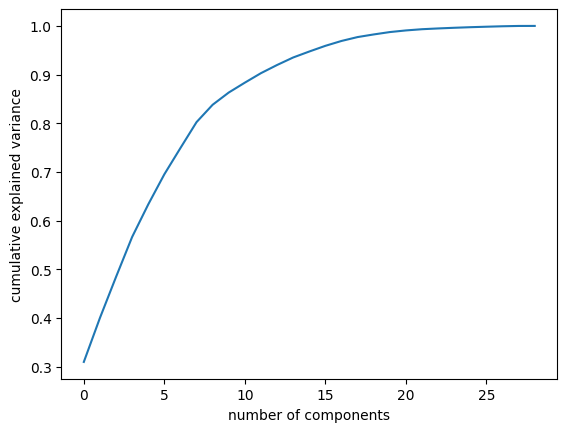

In [26]:
pca = PCA().fit(x_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [27]:
dim_reduce = PCA(n_components=.95)
pcaData = dim_reduce.fit_transform(x_train)
pcaData = pd.DataFrame(pcaData)
pcaData.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
30704,-0.065911,-0.033710,0.050281,-0.079252,0.018650,-0.007556,-0.034255,0.031543,-0.066850,-0.020734,0.012421,0.004593,0.046904,-0.052841,0.002475,-0.037123
186154,-0.061104,-0.073636,-0.063302,0.122202,-0.002651,-0.024399,-0.171544,-0.040400,-0.044731,-0.025990,-0.049684,0.006534,-0.038879,0.050438,0.022764,0.023830
125036,0.001447,-0.007809,0.156424,0.034424,0.041903,-0.037890,-0.022194,0.005165,0.035991,-0.060186,0.051078,-0.097887,0.053713,0.022668,-0.001424,-0.003897
195001,-0.004217,0.060281,0.020216,-0.121467,0.025085,0.002114,0.048279,-0.037175,0.038283,-0.015712,0.023496,0.015339,0.021293,-0.003993,-0.000141,-0.050301
87769,-0.047378,-0.019508,0.106611,0.047930,-0.044737,-0.020456,0.018591,0.012396,-0.073754,0.014946,-0.005362,0.049263,0.053734,-0.039447,0.005080,0.028704


In [28]:
kmeans = KMeans(n_clusters=2, init='k-means++',n_init=10 )

# Fit the model to the data
kmeans.fit(pcaData)

# Get the cluster labels
labels = kmeans.labels_

In [29]:
metrics.rand_score(y_train, labels)

0.9568645967636495

In [30]:
metrics.adjusted_rand_score(y_train, labels)

0.6730915013770039

In [31]:
metrics.adjusted_mutual_info_score(y_train, labels)

0.5504702692001106

Autoencoder effect on K-means:

In [65]:

autoencoder = Sequential([
    GaussianNoise(0.05,input_dim=x_train.shape[1]),
    ## encoding part
    Dense(300, activation='relu',activity_regularizer=regularizers.l2(10e-2)),
    Dense(150, activation='relu',activity_regularizer=regularizers.l2(10e-2)),
    Dense(50, activation='relu',activity_regularizer=regularizers.l2(10e-2)),
    Dense(10, activation='relu',activity_regularizer=regularizers.l2(10e-2)),
    ## decoding part
    Dense(10, activation='relu',activity_regularizer=regularizers.l2(10e-2)),
    Dense(50, activation='relu',activity_regularizer=regularizers.l2(10e-2)),
    Dense(150, activation='relu',activity_regularizer=regularizers.l2(10e-2)),
    Dense(300, activation='relu', activity_regularizer=regularizers.l2(10e-2)),
    ## output layer
    Dense(x_train.shape[1], activation='relu')
])

In [66]:
autoencoder.compile(optimizer="adadelta", loss="mse")

In [67]:
x_norm, x_fraud = x_train[y_train == 0], x_train[y_train == 1]

In [68]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, mode='min', restore_best_weights=True)

In [69]:
autoencoder.fit(x_norm, x_norm,
                batch_size = 32, epochs = 20,
                shuffle = True, validation_split = 0.20,callbacks=[early_stopping]);

Epoch 1/20
5687/5687 [==============================] - 44s 7ms/step - loss: 0.8417 - val_loss: 0.3890
Epoch 2/20
5687/5687 [==============================] - 39s 7ms/step - loss: 0.2720 - val_loss: 0.2087
Epoch 3/20
5687/5687 [==============================] - 40s 7ms/step - loss: 0.1878 - val_loss: 0.1706
Epoch 4/20
5687/5687 [==============================] - 40s 7ms/step - loss: 0.1588 - val_loss: 0.1482
Epoch 5/20
5687/5687 [==============================] - 40s 7ms/step - loss: 0.1402 - val_loss: 0.1330
Epoch 6/20
5687/5687 [==============================] - 38s 7ms/step - loss: 0.1274 - val_loss: 0.1223
Epoch 7/20
5687/5687 [==============================] - 38s 7ms/step - loss: 0.1182 - val_loss: 0.1143
Epoch 8/20
5687/5687 [==============================] - 41s 7ms/step - loss: 0.1112 - val_loss: 0.1083
Epoch 9/20
5687/5687 [==============================] - 39s 7ms/step - loss: 0.1060 - val_loss: 0.1038
Epoch 10/20
5687/5687 [==============================] - 41s 7ms/step - l

In [70]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])
hidden_representation.add(autoencoder.layers[3])
hidden_representation.add(autoencoder.layers[4])

In [72]:
#index = np.random.choice(x_norm.shape[0], 3000, replace=False)
norm_hid_rep = hidden_representation.predict(x_norm)
fraud_hid_rep = hidden_representation.predict(x_fraud)

356/356 [==============================] - 1s 2ms/step


In [73]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
# tsne_plot(rep_x, rep_y, "latent_representation.png")

In [74]:
kmeans = KMeans(n_clusters=2, init='k-means++',n_init=10 )

# Fit the model to the data
kmeans.fit(rep_x)

# Get the cluster labels
labels = kmeans.labels_

In [75]:
metrics.rand_score(rep_y, labels)

0.922151901731142

In [76]:
metrics.adjusted_rand_score(rep_y, labels)

0.2393545366673183

In [77]:
metrics.adjusted_mutual_info_score(rep_y, labels)

0.18659565336482775

DBSCAN (crashed)

In [35]:
x_train.sample(1).to_numpy()

array([[0.9692907 , 0.73709985, 0.8507748 , 0.21083817, 0.74907658,
        0.26827478, 0.25692419, 0.78626239, 0.43781825, 0.53024036,
        0.18264384, 0.66675187, 0.50110399, 0.60824978, 0.34544287,
        0.4506552 , 0.74032542, 0.71304629, 0.55228859, 0.58646777,
        0.56495398, 0.52172551, 0.65769211, 0.32814976, 0.59130318,
        0.42853866, 0.41684695, 0.31524413, 0.0174418 ]])

In [36]:
dist = lambda a,b: np.linalg.norm(a-b)
dist(np.array([1,1]),np.array([0,0]))

1.4142135623730951

In [37]:
fraud_eps_sample = []
x_train_fraud = x_train[y_train==1.0]
for i in range(100):
  a = x_train_fraud.sample(1).to_numpy()
  b = x_train_fraud.sample(1).to_numpy()
  fraud_eps_sample.append(dist(a,b))
fraud_eps_mean = np.mean(fraud_eps_sample)
fraud_eps_std = np.std(fraud_eps_sample)

print(fraud_eps_mean,fraud_eps_std)

0.6480270751690784 0.32202781443511413


In [38]:
non_fraud_eps_sample = []
x_train_non_fraud = x_train[y_train==0.0]
for i in range(100):
  a = x_train_non_fraud.sample(1).to_numpy()
  b = x_train_non_fraud.sample(1).to_numpy()
  non_fraud_eps_sample.append(dist(a,b))
non_fraud_eps_mean = np.mean(non_fraud_eps_sample)
non_fraud_eps_std = np.std(non_fraud_eps_sample)

print(non_fraud_eps_mean,non_fraud_eps_std)

0.28629345457553884 0.07550073432234398


In [39]:
eps = max(fraud_eps_mean,non_fraud_eps_mean)+max(fraud_eps_std,non_fraud_eps_std)
eps

0.9700548896041925

In [40]:
from sklearn.cluster import DBSCAN

In [ ]:
dbscan = DBSCAN(eps=1.3, metric='euclidean')
# Fit the model to the data
dbscan.fit(x_train)

In [ ]:
# Get the cluster labels
labels = dbscan.labels_

In [ ]:
metrics.rand_score(y_train, labels)

In [ ]:
metrics.adjusted_rand_score(y_train, labels)

In [ ]:
metrics.adjusted_mutual_info_score(y_train, labels)

2. Classification

Logistic Regression

In [ ]:
clf = LogisticRegression(solver="lbfgs").fit(x_train, y_train)
y_pred = clf.predict(x_test)

print ("")
print ("Classification Report: ")
print (classification_report(y_test, y_pred))

print ("")
print ("Accuracy Score: ", accuracy_score(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.69      0.85      0.76        98

    accuracy                           1.00     56962
   macro avg       0.84      0.92      0.88     56962
weighted avg       1.00      1.00      1.00     56962


Accuracy Score:  0.9990695551420246


SVM

In [79]:
from sklearn import svm
from sklearn.linear_model import SGDClassifier

Linear SVM

In [86]:
clf = SGDClassifier(max_iter=4000, early_stopping=True, tol=1e-4).fit(x_train, y_train)
y_pred = clf.predict(x_test)

print ("")
print ("Classification Report: ")
print (classification_report(y_test, y_pred))

print ("")
print ("Accuracy Score: ", accuracy_score(y_test, y_pred))



Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.85      0.84        98

    accuracy                           1.00     56962
   macro avg       0.91      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962


Accuracy Score:  0.9994382219725431


Kernel SVM

In [87]:
clf = svm.SVC(kernel="rbf").fit(x_train, y_train)
y_pred = clf.predict(x_test)

print ("")
print ("Classification Report: ")
print (classification_report(y_test, y_pred))

print ("")
print ("Accuracy Score: ", accuracy_score(y_test, y_pred))



Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.76      0.86      0.80        98

    accuracy                           1.00     56962
   macro avg       0.88      0.93      0.90     56962
weighted avg       1.00      1.00      1.00     56962


Accuracy Score:  0.9992802219023208


In [88]:
clf = svm.SVC(kernel="rbf",class_weight={0 : 1, 1: 20}).fit(x_train, y_train)
y_pred = clf.predict(x_test)

print ("")
print ("Classification Report: ")
print (classification_report(y_test, y_pred))

print ("")
print ("Accuracy Score: ", accuracy_score(y_test, y_pred))



Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.90      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.57     56962
weighted avg       1.00      0.98      0.99     56962


Accuracy Score:  0.982567325585478


Deep learning

In [ ]:
model = Sequential([
     GaussianNoise(0.05,input_dim=29),
     Dense(232, activation="relu",kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.L2(0.01)),
     Dense(500, activation="relu",kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.L2(0.01)),
     Dense(500, activation="relu",kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.L2(0.01)),
     Dense(232, activation="relu",kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.L2(0.01)),
     Dense(116, activation="relu",kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.L2(0.01)),
     Dense(58, activation="relu",kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.L2(0.01)),
     Dense(1, activation="sigmoid")
])

In [ ]:
# Input(shape=(29,1)),

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, mode='min', restore_best_weights=True)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1,stratify=y_train)

In [ ]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=5, batch_size=32, verbose=1,callbacks=[early_stopping])

Epoch 1/5
5971/5971 [==============================] - 91s 15ms/step - loss: 0.2391 - accuracy: 0.9803 - val_loss: 0.1258 - val_accuracy: 0.9823
Epoch 2/5
5971/5971 [==============================] - 85s 14ms/step - loss: 0.1285 - accuracy: 0.9848 - val_loss: 0.1295 - val_accuracy: 0.9792
Epoch 3/5
5971/5971 [==============================] - 83s 14ms/step - loss: 0.1188 - accuracy: 0.9856 - val_loss: 0.1200 - val_accuracy: 0.9915
Epoch 4/5
5971/5971 [==============================] - 86s 14ms/step - loss: 0.1136 - accuracy: 0.9860 - val_loss: 0.1003 - val_accuracy: 0.9893
Epoch 5/5
5971/5971 [==============================] - 81s 14ms/step - loss: 0.1100 - accuracy: 0.9863 - val_loss: 0.1071 - val_accuracy: 0.9841


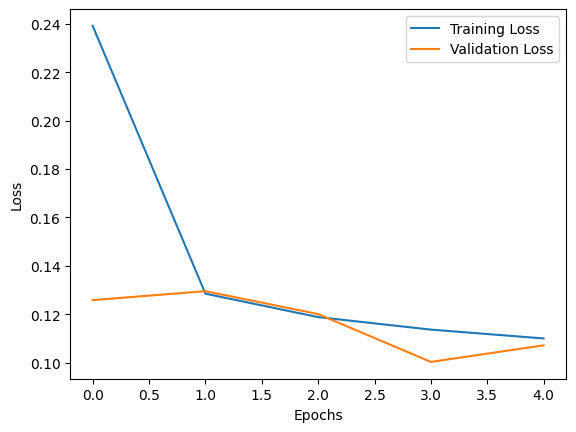

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')

plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')

plt.ylabel('Loss')

plt.legend()

plt.show()

In [ ]:
y_pred = model.predict(x_test)
y_pred = np.array([1 if prob > 0.5 else 0 for prob in y_pred])

1781/1781 [==============================] - 6s 3ms/step


In [ ]:
print ("")
print ("Classification Report: ")
print (classification_report(y_test, y_pred))

print ("")
print ("Accuracy Score: ", accuracy_score(y_test, y_pred))



Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.68      0.77        98

    accuracy                           1.00     56962
   macro avg       0.94      0.84      0.88     56962
weighted avg       1.00      1.00      1.00     56962


Accuracy Score:  0.9992977774656788
